In [538]:
# External libraries used for data handling:
import os
import warnings
import pandas as pd
from datetime import datetime
from dateutil import parser
import pickle
%pylab inline
# Packages for LDA
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary, MmCorpus
import pyLDAvis # LDA visualisation
import pyLDAvis.gensim
# Helper functions
from lda_helper import *

Populating the interactive namespace from numpy and matplotlib


/Users/robin/anaconda3/envs/ada/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist', 'test', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [385]:
# df = pd.read_csv('df_1934_to_1998_JDG.csv')
# df = pd.read_csv('df_1826_to_1874_JDG.csv')
df = pd.read_csv('df_GDL_all.csv')
df2 = pd.read_csv('df_JDG_all.csv')
df = df.append(df2)
df.reset_index(inplace=True)

# parsing all text to strings
df.text=df.text.apply(lambda x: str(x))
# parsing the strings in 'date' column to a pandas Timestamp
df.date = df.date.apply(lambda x: parser.parse(x))

In [400]:
df=df.drop(['index','Unnamed: 0', 'Unnamed: 0.1'],axis=1)
df.head()

,date,newspaper,text,year,month
0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...,1798,02
1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...,1798,02
2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...,1798,02
3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...,1798,03
4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...,1798,03


In [386]:
df_new.shape

(359038, 10)

In [390]:
# adding a year and month column
df_new = pd.DataFrame(columns=['year', 'month'])
df_new.year = df.date.apply(lambda x: datetime.strftime(x, '%Y'))
df_new.month = df.date.apply(lambda x: datetime.strftime(x, '%m'))
df = df.join(df_new, how='outer')

In [392]:
df.to_csv('df_all_merged.csv')

In [393]:
type(df.date[0])
# Selection of articles between dates can be done like so:
# df.date = df.date.apply(lambda x: parser.parse(x))
# df.set_index=('date', inplace=True)
# df[datetime(1851,1,24):datetime(1852,8,22)]

pandas._libs.tslib.Timestamp

# Latent Dirchlet Allocation
The following files are created during this section and can be loaded to resume from a previous point:
* dico.pickle
* corpus.mm
* lda_model_all
* lda_model_all.id2word  
* lda_model_all.expElogbeta.npy 
* lda_model_all.state
* LDAvis_prepared

In [394]:
project_path = '/Users/robin/GIT/ADA/ADA2017_GroupWork/Project_temp/10_topics_vis/'
dico_fp = os.path.join(project_path, 'dico.pickle')
lda_model_filepath = os.path.join(project_path, 'lda_model_all')
ldavis_path = os.path.join(project_path, 'LDAvis_prepared')

In [ ]:
# learn the dictionnary by iterating over all of the articles
dico = Dictionary([article.split() for article in df.text.tolist()])

# filter tokens that are very rare or too common from
# the dictionary. Here we decided to keep all unusual tokens that
# may appear in only one document, but to discard those that are in 
# 40% or more of the corpus
dico.filter_extremes(no_below=0, no_above=0.4)

# reassign integer lda
dico.compactify()
# save dictionary
dico.save(dico_fp)

In [395]:
# load dictionary
dico = Dictionary.load(dico_fp)

In [ ]:
# generate bag-of-word representations for
# all reviews and save them as a matrix

# BoW is saved to file 'corpus.mm'
MmCorpus.serialize(os.path.join(project_path, 'corpus.mm'),
                       bow_generator(df.text.tolist(), dico))  

In [396]:
# load bow_corpus from file
bow_corpus = MmCorpus(os.path.join(project_path, 'corpus.mm'))

In [ ]:
len(bow_corpus)

In [ ]:
# Generating and storing the LDA model
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    lda = LdaMulticore(bow_corpus,
                       num_topics=10,
                       id2word=dico,
                       workers=3)
    # saving the LDA model to disk 
    lda.save(lda_model_filepath)

In [397]:
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

In [ ]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, bow_corpus, dico)

In [ ]:
# saving LDAvis_prepared
with open(ldavis_path, 'wb') as file:
    pickle.dump(LDAvis_prepared, file)

In [398]:
# loading LDAvis_prepared
with open(ldavis_path, 'rb') as file:
    LDAvis_prepared = pickle.load(file)

In [399]:
pyLDAvis.display(LDAvis_prepared)

## Todo
* exporting graphics from pyLDAvis
* time distribution of topics -> see if we can pick out any trends
* time distribution (year) of all votation articles
* comparison of GDL vs JDG
* seasonal comparison, ie. a on a month-to-month basis

# Data analysis: votations through time
We would now like to extract the topic distribution of each article into a `DataFrame` and join this to our main `DataFrame`. In this way we can make plots of the evolution of different topics throughout time.

The column titles correspond to the topic in question and the values are
the coefficient of each topic

In [ ]:
df_new = pd.DataFrame()
for bow in bow_corpus:
    rk = lda.get_document_topics(bow, minimum_probability=0)
    ziped = [p[1] for p in rk]
    df_topicscore = pd.DataFrame(ziped)
    df_topicscore = df_topicscore.transpose()
    df_new = df_new.append(df_topicscore)

In [403]:
# Saving df
# df_new.to_csv('df_new_topics.csv')
# Loading df
df_new=pd.read_csv('df_new_topics.csv')

In [460]:
df_new = df_new.drop(['Unnamed: 0'],axis=1)
df_new.columns = range(1, lda.num_topics+1)
df_new.head()

,1,2,3,4,5,6,7,8,9,10
0,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


In [574]:
# df = df.join(df_new)
# Saving df
df.to_csv('df_merged_with_topics.csv')

In [577]:
df.head()

,date,newspaper,text,year,month,1,2,3,4,5,6,7,8,9,10
0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...,1798,02,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...,1798,02,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...,1798,02,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...,1798,03,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...,1798,03,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


In [421]:
df[df['year']=='1798'].head()

,date,newspaper,text,year,month,1,2,3,4,5,6,7,8,9,10
0,1798-02-02,GDL,membre lecture lettre berne janvier conseil ce...,1798,02,0.002382,0.084616,0.002382,0.464683,0.002382,0.002382,0.002381,0.002382,0.434029,0.002381
1,1798-02-05,GDL,charger arrêter constitution fonder biser libe...,1798,02,0.003334,0.003334,0.003335,0.383314,0.003334,0.003334,0.003334,0.260981,0.003334,0.332365
2,1798-02-24,GDL,donner nommer acte fou élection décret antérie...,1798,02,0.003227,0.003227,0.003226,0.858578,0.003227,0.003227,0.003226,0.003227,0.115607,0.003227
3,1798-03-02,GDL,patrie droit nationale vouloir déchirer indign...,1798,03,0.004349,0.004349,0.137790,0.187747,0.004349,0.004349,0.004349,0.004349,0.448540,0.199829
4,1798-03-13,GDL,séparation droit voter fauteur orange ennemi f...,1798,03,0.007694,0.417738,0.007693,0.520707,0.007695,0.007694,0.007695,0.007694,0.007696,0.007695


In [441]:
df_year = pd.DataFrame(columns=['year'])
df_year.year = df.year.unique()
# df_year

In [531]:
df_year = pd.DataFrame(columns=df.columns[5:])
# years=['1798','1799']
counts =[]
for year in df.year.unique():
    counts.append(df[df['year']==year].shape[0])
    df_year = df_year.append(df[df['year']==year][df.columns[5:]].sum(), ignore_index=True)
    
df_year = df_year.join(pd.DataFrame(df.year.unique(), columns=['year']))
df_year = df_year.join(pd.DataFrame(counts, columns=['counts']))

In [571]:
# df_year.to_csv('df_year.csv')
df_year = pd.read_csv('df_year.csv')

In the following graph we can get an overview of the number of articles we have over the course of the years. It doesn't come as much surprise that the recent years have a lot more articles, with the exception being 1998. This is due to the dataset ending in February 1998, and thus it not being a complete year.

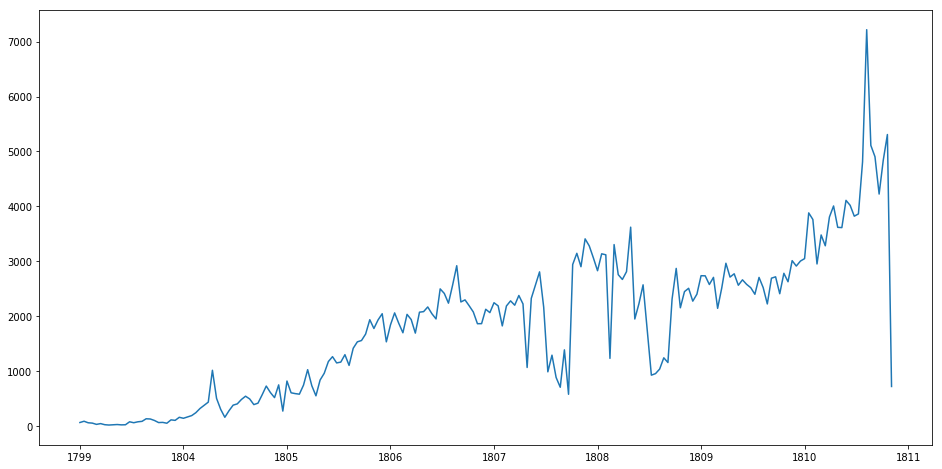

In [570]:
ax = df_year.counts.plot(kind='line', figsize=(16,8))
ax.set_xticklabels(df_year.year);

In [528]:
df[df['year']==year].shape[0]

720

### For maximum sorting:

In [ ]:
dist = lda.get_document_topics(bow_corpus[2])
dist
# dist = [p[1] for p in dist] # returns probabilities for reach topic
# dist.index(max(dist))

In [ ]:
dist.sort(key = (lambda x: x[1]) , reverse = True)


In [ ]:
# df=df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df.columns